In [2]:
from active_coresets.quantum_algorithms import RQBM
from active_coresets.coreset_algorithms import bayesian_inference
from active_coresets.classical_algorithms import GIGACoreset
from active_coresets.data_structures import Model, Coreset
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import List

2022-02-15 09:40:48.480295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-15 09:40:48.480325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class RQBMModel(Model):
    def __init__(self, rqbm: RQBM, beta: float):
        self.rqbm = rqbm
        self.beta = beta
        self.model_dist = self.rqbm.get_distribution(self.beta)
    
    def evaluate_on_coreset(self, coreset: Coreset) -> float:
        return 0.0

    def evaluate_on_point(self, data: np.ndarray, probability: float) -> float:
        converted_data = -2 * data + np.ones(data.shape[0])
        model_probability = self.model_dist[tuple(converted_data)]
        return 1 - probability * np.log(probability / model_probability)

In [3]:
def RQBM_loglikelihood(data: np.ndarray, models: List[RQBMModel]) -> np.ndarray:
    data_dict = {}
    for pt in data:
        tup_pt = tuple(pt)
        if tup_pt in data_dict:
            data_dict[tup_pt] += 1
        else:
            data_dict[tup_pt] = 1
    data_dist = {k: v / sum(data_dict.values()) for k, v in data_dict.items()}

    ll_vecs = np.zeros((data.shape[0], len(models)))
    for i in range(data.shape[0]):
        for j in range(len(models)):
            ll_vecs[i][j] = models[j].evaluate_on_point(data[i], data_dist[tuple(data[i])])
    return ll_vecs

In [3]:
def plot_loss_history(loss_history: List[float]):
    plt.plot(loss_history)
    plt.show()

In [5]:
def make_model(rqbm, beta) -> RQBMModel:
    return RQBMModel(rqbm, beta)

In [4]:
dataset = np.array([np.random.randint(0, 2, size=4) for _ in range(100)])


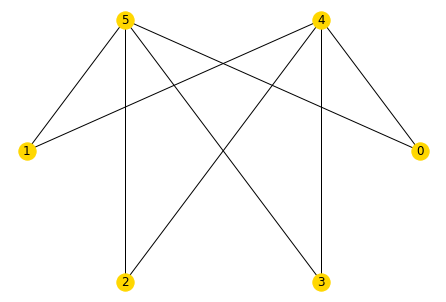

In [5]:
visible = [0, 1, 2, 3]
hidden = [4, 5]
edges = [(i, j) for i in visible for j in hidden]

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_circular(G, with_labels=True, node_color='gold')

beta = 10.0

In [35]:
import importlib
import active_coresets
importlib.reload(active_coresets.quantum_algorithms)
importlib.reload(active_coresets.classical_algorithms)
importlib.reload(active_coresets.coreset_algorithms)
importlib.reload(active_coresets.QBM)
importlib.reload(active_coresets.qmc_tim_qbm)
importlib.reload(active_coresets.population_annealing)
from active_coresets.quantum_algorithms import RQBM
from active_coresets.coreset_algorithms import bayesian_inference
import active_coresets.QBM
from active_coresets.QBM import QuantumBoltzmannMachine

In [ ]:
A = GIGACoreset(list(dataset), RQBM_loglikelihood)
B = RQBM(G, visible, hidden, beta)

final_model, coreset = bayesian_inference(list(dataset), make_model, 0, 16, A, B, 20)

In [7]:
data_dict = {}
for pt in dataset:
    z_pt = tuple(-2 * pt + np.ones(pt.shape[0]))
    if z_pt in data_dict:
        data_dict[z_pt] += 1
    else:
        data_dict[z_pt] = 1
data_dist = {k: v / sum(data_dict.values()) for k, v in data_dict.items()}

In [ ]:

model_dist = B.rqbm.get_distribution(B.beta)
B.rqbm.plot_dist(model_dist, data_dist)


In [ ]:
coreset_qbm = QuantumBoltzmannMachine(G, visible, hidden, 2)
coreset_qbm.exact_train_coreset(coreset, beta=B.beta)
coreset_model_dist = coreset_qbm.get_distribution(beta=B.beta)
coreset_qbm.plot_dist(coreset_model_dist, data_dist)
plot_loss_history(coreset_qbm.loss_history)

Aim for M=15

In [ ]:
optimal_qbm = QuantumBoltzmannMachine(G, visible, hidden, 2)
optimal_qbm.exact_optimization(data_dist, beta=1, max_epoch=20)
optimal_model_dist = optimal_qbm.get_distribution(beta=1)
optimal_qbm.plot_dist(optimal_model_dist, data_dist)
plot_loss_history(optimal_qbm.loss_history)

In [16]:
z_data = (-2 * dataset + np.ones(dataset.shape)).astype(np.float32)

In [36]:

approx_qbm = QuantumBoltzmannMachine(G, visible, hidden, 2)
approx_qbm.classical_train(z_data, epochs=1)

Epoch 1/1:
....Batch: 1/10
....Batch: 2/10
....Batch: 3/10
....Batch: 4/10
....Batch: 5/10
....Batch: 6/10
....Batch: 7/10
....Batch: 8/10
....Batch: 9/10
....Batch: 10/10
Training done!


/home/jviszlai/Envs/coresets/lib/python3.7/site-packages/matplotlib/transforms.py:788: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


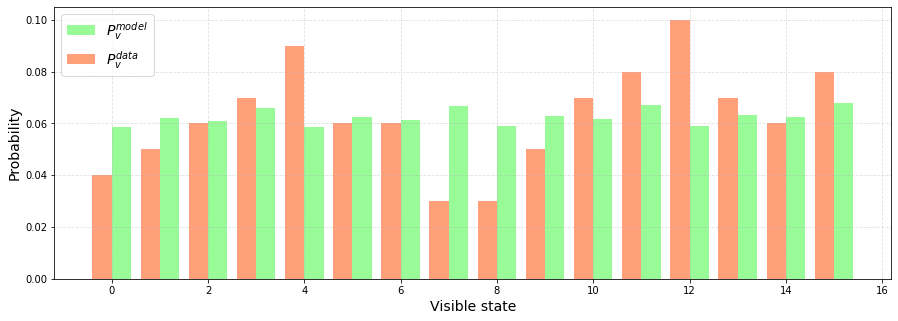

In [37]:
model_dist = approx_qbm.get_distribution(beta=1)
approx_qbm.plot_dist(model_dist, data_dist)

In [57]:
samples = approx_qbm.sample(10000)[:,:4]
sample_dict = {}
for z_pt in samples:
    pt = tuple(-(z_pt - np.ones(z_pt.shape[0]))/2)
    if pt in sample_dict:
        sample_dict[pt] += 1
    else:
        sample_dict[pt] = 1
sample_dist = {k: v / sum(sample_dict.values()) for k, v in sample_dict.items()}

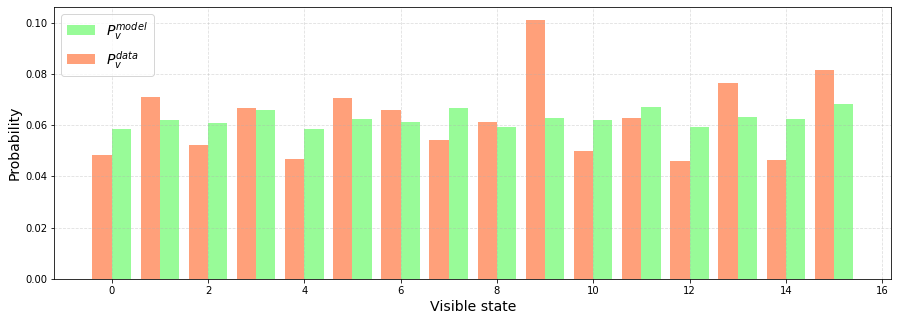

In [58]:
approx_qbm.plot_dist(model_dist, sample_dist)

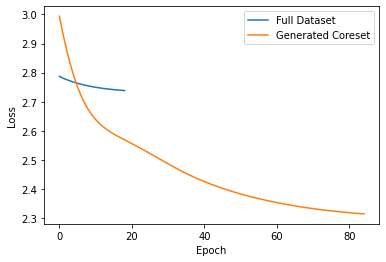

In [32]:
plt.plot(optimal_qbm.loss_history, label='Full Dataset')
plt.plot(coreset_qbm.loss_history, label='Generated Coreset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()